In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, make_scorer, precision_score, f1_score, confusion_matrix, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
import nltk
from nltk.corpus import stopwords

In [2]:
#Original data frame

df = pd.read_csv("G:/My Drive/Applied Data Science Mining - 502/Final Project/bbc_news_text_complexity_summarization.csv")

In [3]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean(df, column_name):
    existing_words = set()
    row_data = []  # List to store rows as dictionaries
    
    for index, text in enumerate(df[column_name]):
        text = text.replace('\n', '')
        words = re.findall(r'\b\w+\b', text.lower())
        filtered_words = [word for word in words if word not in stop_words]
        
        row_dict = {}  # Dictionary to store one row's word counts
        for word in filtered_words:
            existing_words.add(word)
            row_dict[word] = 1
        
        # Add the row dictionary to the list
        row_data.append(row_dict)
    
    # Create a new DataFrame from the collected data
    words_df = pd.DataFrame(row_data).fillna(0)
    
    # Concatenate the new DataFrame with the original one (optional)
    df = pd.concat([df.reset_index(drop=True).drop(column_name, axis=1), words_df], axis=1)
    return df


doc_term_df = clean(df, 'text')

In [4]:
#This process is creating a cosine similarity matrix to determine which records are duplicates to prepare for removal

cosine_df = doc_term_df.iloc[:, 6:31245]

cosine_vectors = cosine_df.values

cosine_matrix = cosine_similarity(cosine_vectors)

#Fill diagonal with NaN so they aren't included when checking for similarity

np.fill_diagonal(
    cosine_matrix, 
    np.nan
)

cosine_sim_df = pd.DataFrame(cosine_matrix, index = cosine_df.index, columns = cosine_df.index)

#This takes just the top half of the matrix to avoid subsetting duplicate indicies

upper_half = np.triu(cosine_sim_df)

upper_df = pd.DataFrame(
    upper_half, 
    columns = cosine_sim_df.columns, 
    index = cosine_sim_df.index
)

#Threshold for determining duplicate is a cosine similarity of .8

indicies = np.argwhere(upper_half > .8)

#Create loop to add indicies to a list to prepare for removal

dup = []

for i, j in indicies:
    dup.append(i)

doc_term_df.drop(
    index = dup, 
    axis = 0, 
    inplace = True
)

#Ensure rows were removed

doc_term_df.shape

(2058, 31246)

In [5]:
#Dropping the 5 columns that aren't words or the label column

columns = doc_term_df.iloc[:, 1:6]

doc_term_df.drop(
    columns = columns, 
    axis = 1, 
    inplace = True
)

In [6]:
#Checking highest and lowest count of words found in articles

sums = doc_term_df.iloc[:, 1:31247].sum().sort_values(ascending = False)

print((sums == 0).sum())
print(sums.head(n=30))

39
said      1746.0
also      1160.0
year      1104.0
would     1062.0
one        988.0
new        899.0
last       844.0
could      799.0
two        799.0
us         781.0
time       766.0
first      746.0
mr         728.0
people     719.0
years      631.0
world      624.0
made       600.0
make       578.0
told       573.0
three      560.0
back       553.0
added      533.0
get        523.0
well       515.0
1          512.0
take       511.0
next       496.0
way        489.0
uk         486.0
like       485.0
dtype: float64


In [7]:
#Prepare for removal of these columns

zero_count_words = sums.index[-39:]

top_30 = sums.index[:31]

combined = top_30.append(zero_count_words)

In [8]:
#Removing from DF and check that it worked

doc_term_df.drop(
    columns = combined, 
    axis = 1, 
    inplace = True
)

doc_term_df.shape

(2058, 31171)

In [9]:
#TF-IDF conversion

df_idf = df.drop(
    index = dup, 
    axis = 0, 
    inplace = False
)

vectorizer = TfidfVectorizer(
    max_features = 1000, 
    max_df = .9, 
    ngram_range = (1, 3)
)

X_vect = vectorizer.fit_transform(df_idf.iloc[:, 0])

X_vect.shape

(2058, 1000)

# Logistic Regression

In [10]:
X = doc_term_df.iloc[:, 1:]
y = doc_term_df.iloc[:, 0]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = .3, random_state = 1)

In [12]:
lr_model01 = LogisticRegression(
    multi_class = 'multinomial', 
    random_state = 1
)

In [13]:
lr_model01.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=1)

In [13]:
lr_pred01 = lr_model01.predict(X_test)

In [14]:
print(classification_report(y_test, lr_pred01))

               precision    recall  f1-score   support

     business       0.95      0.97      0.96       145
entertainment       0.98      0.99      0.99       109
     politics       0.97      0.95      0.96       119
        sport       0.99      0.99      0.99       151
         tech       0.98      0.96      0.97        94

     accuracy                           0.97       618
    macro avg       0.97      0.97      0.97       618
 weighted avg       0.97      0.97      0.97       618



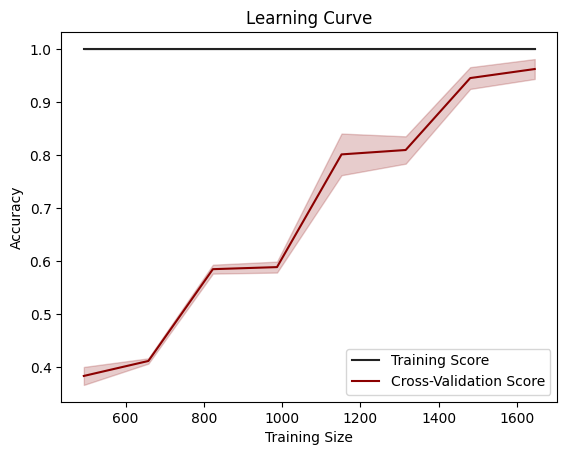

In [21]:
train_sizes, train_scores, test_scores = learning_curve(
    lr_model01, X, y, cv = 5, scoring = 'accuracy', n_jobs = -1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label = "Training Score", color = "#222222")
plt.plot(train_sizes, test_mean, label = "Cross-Validation Score", color = "#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#222222", alpha = 0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#8B0000", alpha = 0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.show()

In [15]:
#Inspect the log odds of each word

feature_names = X.columns

#Take the average of each feature across the target labels

mean_importance = np.mean(
    np.abs(lr_model01.coef_), 
    axis=0
)

#Create data frame and add average coefficient value for each feature, and sort in descending order

importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Mean Importance': mean_importance}
)

importance_df = importance_df.sort_values(
    by = 'Mean Importance', 
    ascending=False
)

In [16]:
#Preparing to remove words that don't contribute to model

dimension_reduction_index = importance_df[importance_df['Mean Importance'] <= 0.005].index
dimension_reduction_values = importance_df.iloc[dimension_reduction_index, 0].values

In [17]:
#Remove

important_terms_df = doc_term_df.drop(
    columns = dimension_reduction_values, 
    axis = 1, 
    inplace= False
)

important_terms_df.shape

(2058, 12092)

In [18]:
#Subset the predictors of the new data, split the sample into training and test samples then run the LR model again

X02 = important_terms_df.iloc[:, 1:]

X_train02, X_test02, y_train02, y_test02 = train_test_split(
    X02, y, test_size = .3, random_state = 2)

lr_model02 = LogisticRegression(
    multi_class = 'multinomial', 
    random_state = 2
)

lr_model02.fit(
    X_train02, 
    y_train02
)

lr_pred02 = lr_model02.predict(
    X_test02
)

print(classification_report(y_test02, lr_pred02))

               precision    recall  f1-score   support

     business       0.95      0.98      0.96       147
entertainment       0.99      0.96      0.98       107
     politics       0.97      0.98      0.98       109
        sport       0.99      1.00      0.99       149
         tech       0.97      0.92      0.95       106

     accuracy                           0.97       618
    macro avg       0.97      0.97      0.97       618
 weighted avg       0.97      0.97      0.97       618



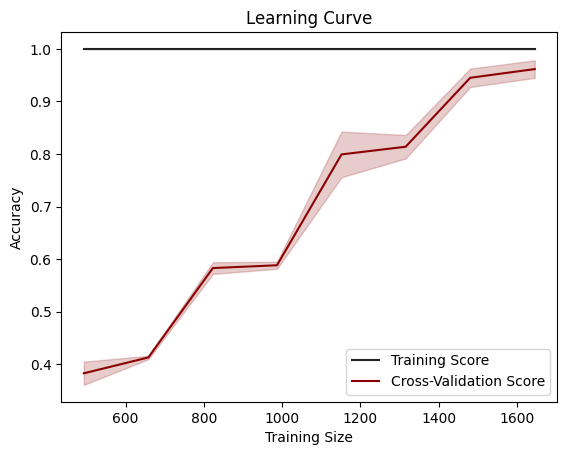

In [22]:
train_sizes, train_scores, test_scores = learning_curve(
    lr_model02, X02, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color="#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

In [24]:
X_train03, X_test03, y_train03, y_test03 = train_test_split(
    X_vect, y, test_size = .3, random_state = 3) #Split the TF-IDF converted data

lr_model03 = LogisticRegression(
    multi_class = 'multinomial', 
    random_state = 3
)

lr_model03.fit(X_train03, y_train03)

lr_pred03 = lr_model03.predict(X_test03)

print(classification_report(y_test03, lr_pred03))

               precision    recall  f1-score   support

     business       0.92      0.95      0.93       160
entertainment       0.99      0.95      0.97        93
     politics       0.95      0.91      0.93       129
        sport       0.99      1.00      1.00       142
         tech       0.95      0.97      0.96        94

     accuracy                           0.96       618
    macro avg       0.96      0.96      0.96       618
 weighted avg       0.96      0.96      0.96       618



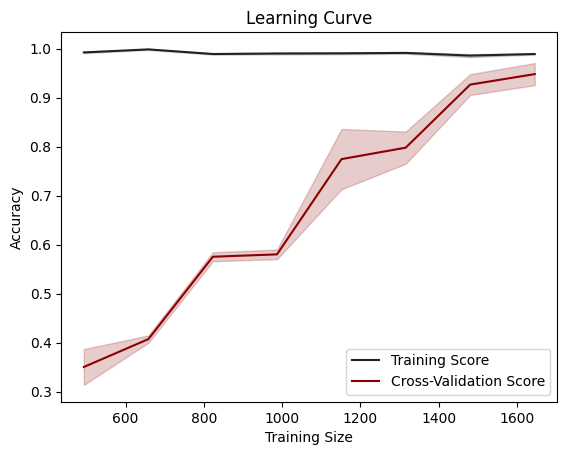

In [25]:
train_sizes, train_scores, test_scores = learning_curve(
    lr_model03, X_vect, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color="#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Random Forest

In [26]:
#Encode the target variable to prepare for Random Forest modeling

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Run the train/test split again with new data

X_train_rf01, X_test_rf01, y_train_rf01, y_test_rf01 = train_test_split(
    X, y_encoded, test_size = .3, random_state = 4)

rf_model01 = RandomForestClassifier(
    min_samples_split = 5, 
    oob_score = True, 
    random_state = 4
)

rf_model01.fit(X_train_rf01, y_train_rf01)

rf_preds01 = rf_model01.predict(X_test_rf01)

print(classification_report(y_test_rf01, rf_preds01))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       158
           1       0.98      0.90      0.94       107
           2       0.96      0.91      0.94       115
           3       0.94      1.00      0.97       138
           4       0.97      0.92      0.94       100

    accuracy                           0.95       618
   macro avg       0.95      0.94      0.95       618
weighted avg       0.95      0.95      0.95       618



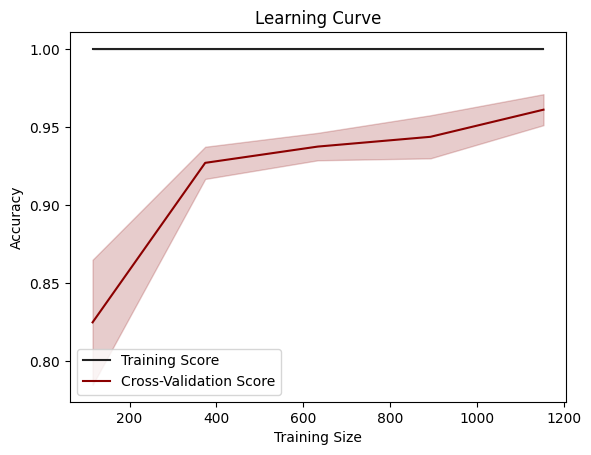

In [11]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_model01, X, y_encoded, cv=5, scoring='accuracy', n_jobs=-1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color="#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

In [27]:
X_train_rf02, X_test_rf02, y_train_rf02, y_test_rf02 = train_test_split(
    X02, y_encoded, test_size = .3, random_state = 5)

rf_model02 = RandomForestClassifier(
    min_samples_split = 5, 
    oob_score = True, 
    random_state = 5
)

rf_model02.fit(X_train_rf02, y_train_rf02)

rf_preds02 = rf_model02.predict(X_test_rf02)

print(classification_report(y_test_rf02, rf_preds02))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       143
           1       0.98      0.95      0.97       109
           2       0.99      0.97      0.98       112
           3       0.97      0.99      0.98       153
           4       1.00      0.96      0.98       101

    accuracy                           0.98       618
   macro avg       0.98      0.98      0.98       618
weighted avg       0.98      0.98      0.98       618



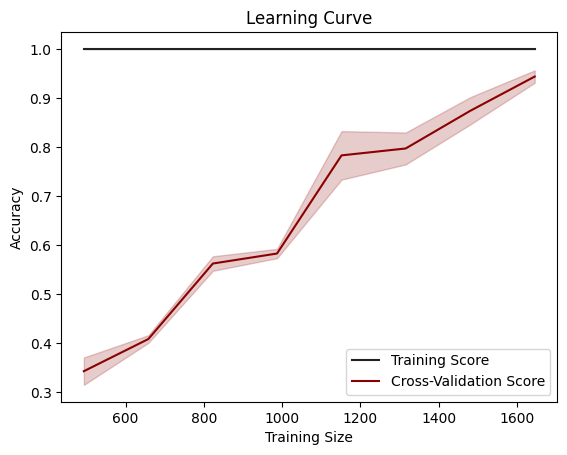

In [28]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_model02, X02, y_encoded, cv = 5, scoring = 'accuracy', n_jobs = -1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label = "Training Score", color = "#222222")
plt.plot(train_sizes, test_mean, label = "Cross-Validation Score", color = "#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#222222", alpha = 0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#8B0000", alpha = 0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.show()

In [47]:
X_train_rf03, X_test_rf03, y_train_rf03, y_test_rf03 = train_test_split(
    X_vect, y_encoded, test_size = .3, random_state = 6)

rf_model03 = RandomForestClassifier(
    min_samples_split = 5, 
    oob_score = True, 
    random_state = 6
)

rf_model03.fit(X_train_rf03, y_train_rf03)

rf_preds03 = rf_model03.predict(X_test_rf03)

print(classification_report(y_test_rf03, rf_preds03))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       135
           1       0.95      0.94      0.95       112
           2       0.97      0.89      0.93       126
           3       0.95      0.98      0.96       139
           4       0.97      0.90      0.93       106

    accuracy                           0.94       618
   macro avg       0.94      0.93      0.94       618
weighted avg       0.94      0.94      0.94       618



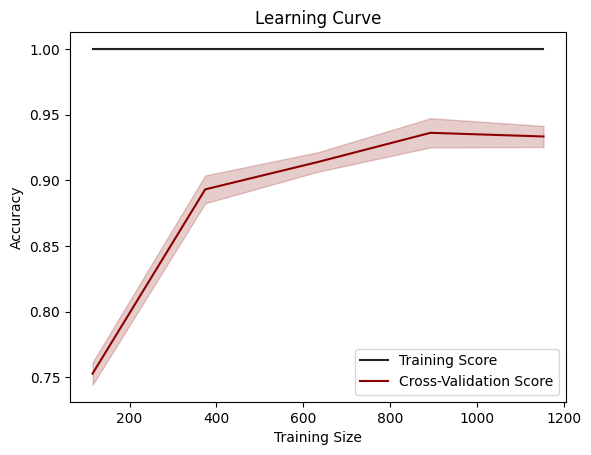

[0.74415995 0.8824326  0.90647425 0.925      0.92529456]
[0.76139561 0.90367851 0.92130353 0.94722222 0.94137211]


In [77]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_model03, X_vect, y_encoded, cv=5, scoring='accuracy', n_jobs=-1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color="#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

In [73]:
#Hyper parameter tuning for RandomForest model with TF-IDF data

param_grid = {
    'n_estimators': [100, 500, 750],
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_features': ['sqrt', 'log2', 25]
}

# Perform Grid Search
grid_search = GridSearchCV(
    rf_model03, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose = 1
)

grid_search.fit(X_train_rf03, y_train_rf03)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'max_features': 25, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 750}
Best Cross-Validation Score: 0.9263888888888889


In [74]:
rf_model04 = RandomForestClassifier(
    n_estimators = 750, 
    min_samples_split = 10, 
    min_samples_leaf = 10, 
    max_features = 25, 
    oob_score = True, 
    random_state = 17
)

rf_model04.fit(X_train_rf03, y_train_rf03)

rf_preds04 = rf_model03.predict(X_test_rf03)

print(classification_report(y_test_rf03, rf_preds04))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       135
           1       0.95      0.94      0.95       112
           2       0.97      0.89      0.93       126
           3       0.95      0.98      0.96       139
           4       0.97      0.90      0.93       106

    accuracy                           0.94       618
   macro avg       0.94      0.93      0.94       618
weighted avg       0.94      0.94      0.94       618



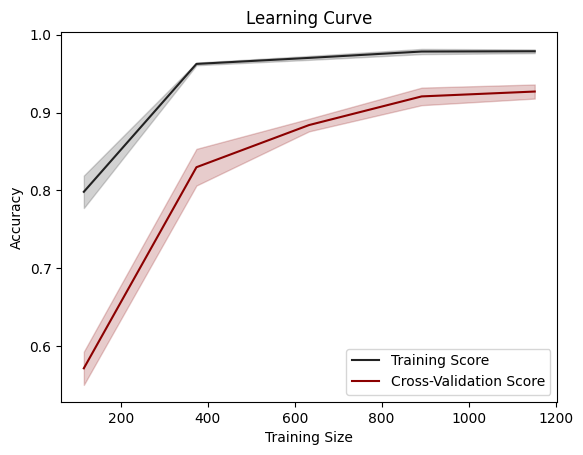

In [76]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_model04, X_vect, y_encoded, cv=5, scoring='accuracy', n_jobs=-1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color="#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# SVM

In [14]:
#Model with full data set

svm_model01 = LinearSVC(
    dual = True, 
    random_state = 7)

svm_model01.fit(X_train, y_train)

svm_preds01 = svm_model01.predict(X_test)

print(classification_report(y_test, svm_preds01))

               precision    recall  f1-score   support

     business       0.95      0.96      0.95       145
entertainment       0.99      1.00      1.00       109
     politics       0.96      0.94      0.95       119
        sport       0.99      0.99      0.99       151
         tech       0.98      0.97      0.97        94

     accuracy                           0.97       618
    macro avg       0.97      0.97      0.97       618
 weighted avg       0.97      0.97      0.97       618



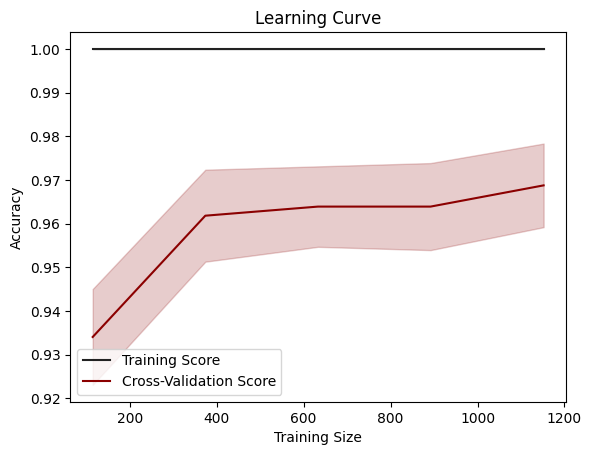

In [15]:
train_sizes, train_scores, test_scores = learning_curve(
    svm_model01, X, y, cv = 5, scoring = 'accuracy', n_jobs = -1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color = "#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color = "#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

In [50]:
#Model with important features data

svm_model02 = LinearSVC(
    dual = True, 
    random_state = 8)

svm_model02.fit(X_train02, y_train02)

svm_preds02 = svm_model02.predict(X_test02)

print(classification_report(y_test02, svm_preds02))

               precision    recall  f1-score   support

     business       0.95      0.98      0.97       147
entertainment       0.99      0.96      0.98       107
     politics       0.96      0.98      0.97       109
        sport       0.99      1.00      0.99       149
         tech       0.97      0.92      0.95       106

     accuracy                           0.97       618
    macro avg       0.97      0.97      0.97       618
 weighted avg       0.97      0.97      0.97       618



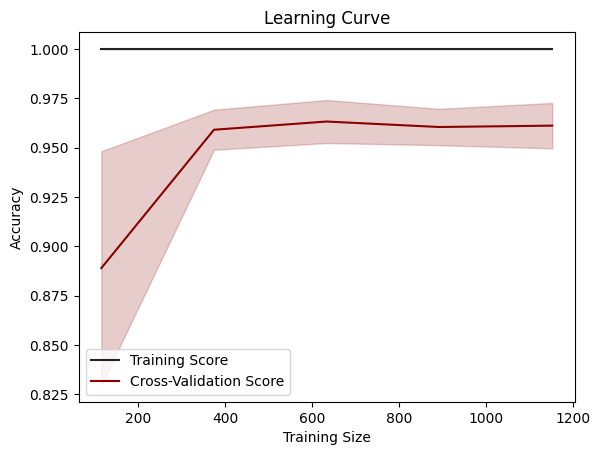

[0.82967757 0.94886893 0.95230251 0.95120382 0.94961601]
[0.9481002  0.96918662 0.97408638 0.96962951 0.97260621]


In [71]:
train_sizes, train_scores, test_scores = learning_curve(
    svm_model02, X02, y, cv=5, scoring = 'accuracy', n_jobs = -1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color = "#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color = "#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

In [51]:
#Model with TF-IDF conversion data

svm_model03 = LinearSVC(
    dual = True, 
    random_state = 9
)

svm_model03.fit(X_train03, y_train03)

svm_preds03 = svm_model03.predict(X_test03)

print(classification_report(y_test03, svm_preds03))

               precision    recall  f1-score   support

     business       0.92      0.96      0.94       160
entertainment       0.99      0.91      0.95        93
     politics       0.95      0.92      0.94       129
        sport       0.99      1.00      0.99       142
         tech       0.95      0.98      0.96        94

     accuracy                           0.96       618
    macro avg       0.96      0.95      0.96       618
 weighted avg       0.96      0.96      0.96       618



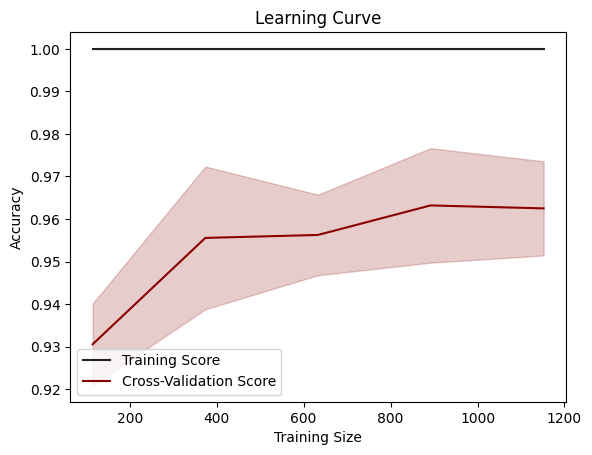

In [52]:
train_sizes, train_scores, test_scores = learning_curve(
    svm_model03, X_vect, y, cv = 5, scoring = 'accuracy', n_jobs = -1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color = "#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color = "#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# VIF analysis to check for overfitting

In [22]:
vif = X02.iloc[:, 0:400]

vif_data = pd.DataFrame()
vif_data["feature"] = vif.columns
vif_data["VIF"] = [variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])]

C:\Users\Taylor\miniconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [33]:
#Find features with VIF over 5

drop = vif_data[vif_data['VIF'] >= 5].index
drop

Index([68, 230, 244, 300, 304, 313], dtype='int64')

In [37]:
#Drop those features

vif_data.drop(
    index = drop, 
    axis = 0, 
    inplace = True
)

In [39]:
#identify features with inf values and drop them

vif_data = vif_data[~vif_data['VIF'].isin([np.inf, -np.inf])]

#Check for removal

(vif_data['VIF'].map(np.isinf)).sum()

0

In [40]:
#Create a list of the remaining features to be used to create a subset of data

to_keep = vif_data['feature'].tolist()

In [41]:
#Create a subset to be used for modeling

subset = doc_term_df[to_keep]

# Logistic Regression with VIF subset

In [42]:
X1, X_t, y1, y_t = train_test_split(
    subset, y, test_size = .3, random_state = 30)

In [43]:
model = LogisticRegression(random_state = 30)

model.fit(X1, y1)

preds = model.predict(X_t)

print(classification_report(y_t, preds))

               precision    recall  f1-score   support

     business       0.92      0.80      0.86       149
entertainment       0.77      0.90      0.83        90
     politics       0.91      0.79      0.84       110
        sport       0.91      0.92      0.91       179
         tech       0.73      0.88      0.80        90

     accuracy                           0.86       618
    macro avg       0.85      0.86      0.85       618
 weighted avg       0.87      0.86      0.86       618



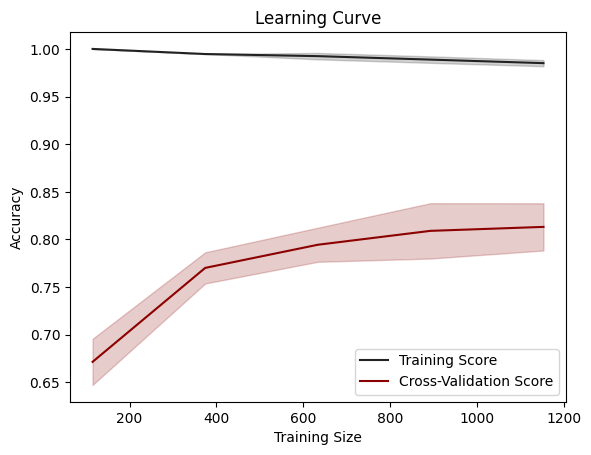

In [116]:
train_sizes, train_scores, test_scores = learning_curve(
    model, subset, y, cv = 5, scoring = 'accuracy', n_jobs = -1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color = "#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color = "#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#222222", alpha = 0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#8B0000", alpha = 0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# PCA decomposition

In [44]:
#Fit PCA to entire dataset then determine best number of components to break down into

pca = PCA()

pca.fit(X)

PCA()

In [45]:
#Find number of Eigenvalues that are greater than one

eigenvalues = pca.explained_variance_
num_components = (eigenvalues > 1).sum()
num_components

In [49]:
#Number of components that explain 95% of the variance of the data

cum_var = pca.explained_variance_ratio_.cumsum()
num = (cum_var < .95).sum() + 1
num

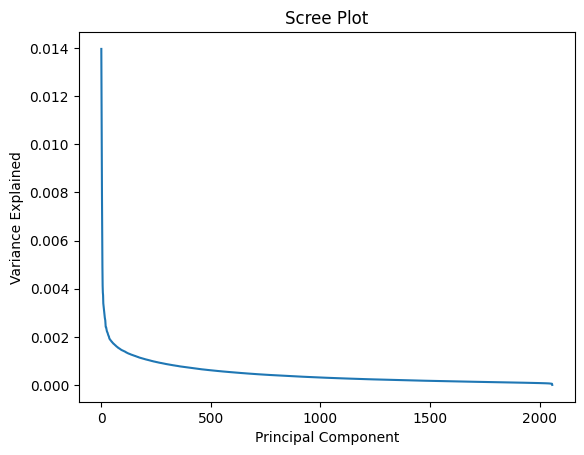

In [133]:
#Plot explained variance of each feature in descending order

import matplotlib.pyplot as plt

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

In [29]:
#Fitting training and test data to 100 components

pca = PCA(n_components = 100)

pca_model = pca.fit_transform(X_train)

pca_model_test = pca.transform(X_test)

pca_full = pca.fit_transform(X)

# Logistic Regression with PCA decomposition

In [35]:
lr_pca = LogisticRegression(
    multi_class = 'multinomial', 
    random_state = 44
)

lr_pca.fit(pca_model, y_train)

lr_pca_preds = lr_pca.predict(pca_model_test)

print(classification_report(y_test, lr_pca_preds))

               precision    recall  f1-score   support

     business       0.92      0.96      0.94       145
entertainment       0.96      0.99      0.98       109
     politics       0.98      0.92      0.95       119
        sport       1.00      0.99      0.99       151
         tech       0.96      0.97      0.96        94

     accuracy                           0.96       618
    macro avg       0.96      0.96      0.96       618
 weighted avg       0.97      0.96      0.96       618



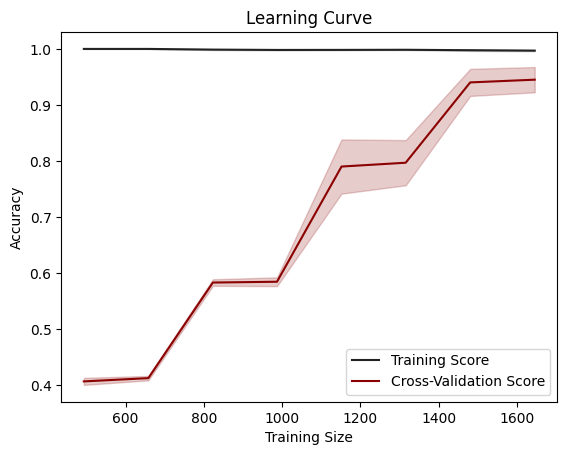

In [36]:
train_sizes, train_scores, test_scores = learning_curve(
    lr_pca, pca_full, y, cv = 5, scoring = 'accuracy', n_jobs = -1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label = "Training Score", color = "#222222")
plt.plot(train_sizes, test_mean, label = "Cross-Validation Score", color = "#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.show()

# Fitting Random Forest model to PCA decomposition

In [33]:
rf_pca = RandomForestClassifier(
    min_samples_split = 5, 
    random_state = 45
)

rf_pca.fit(pca_model, y_train)

rf_pca_preds = rf_pca.predict(pca_model_test)

print(classification_report(y_test, rf_pca_preds))

               precision    recall  f1-score   support

     business       0.90      0.97      0.93       145
entertainment       0.93      0.97      0.95       109
     politics       0.98      0.88      0.93       119
        sport       0.99      0.99      0.99       151
         tech       0.98      0.94      0.96        94

     accuracy                           0.95       618
    macro avg       0.96      0.95      0.95       618
 weighted avg       0.95      0.95      0.95       618



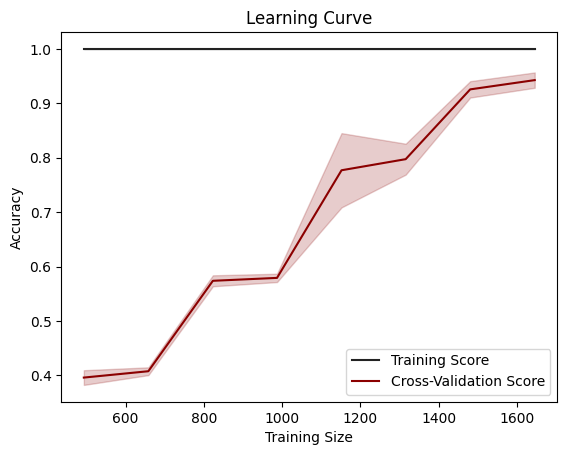

In [34]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_pca, pca_full, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label = "Training Score", color = "#222222")
plt.plot(train_sizes, test_mean, label = "Cross-Validation Score", color = "#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.show()

# Fitting SVM model to PCA decomposition

In [62]:
svm01 = SVC(random_state = 40)

svm01.fit(pca_model, y_train)

preds = svm01.predict(pca_model_test)

print(classification_report(y_test, preds))

               precision    recall  f1-score   support

     business       0.92      0.97      0.95       145
entertainment       0.96      0.98      0.97       109
     politics       0.98      0.91      0.94       119
        sport       1.00      0.98      0.99       151
         tech       0.95      0.97      0.96        94

     accuracy                           0.96       618
    macro avg       0.96      0.96      0.96       618
 weighted avg       0.96      0.96      0.96       618



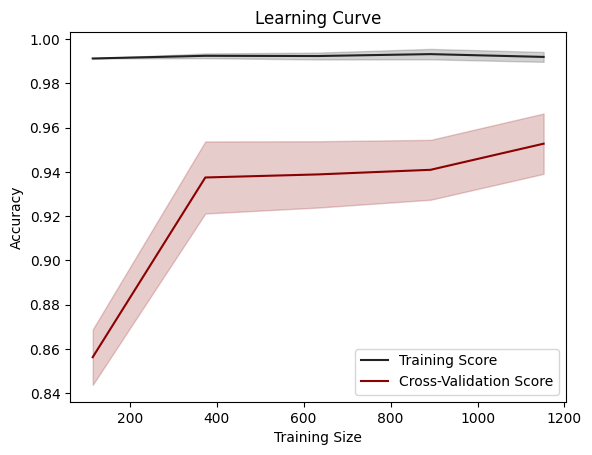

In [63]:
train_sizes, train_scores, test_scores = learning_curve(
    svm01, pca_full, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color="#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# PCA SVM model hyperparameter tuning

In [65]:
param_grid = {
    'C': [.001, .01, .1, 1, 10],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': [.0001, .001, .01, .1, 1],
    'degree': [2, 3, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(
    svm01, 
    param_grid, 
    cv = 5, 
    scoring = 'accuracy', 
    verbose = 1
)

grid_search.fit(pca_model, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'C': 0.1, 'degree': 2, 'gamma': 0.0001, 'kernel': 'linear'}
Best Cross-Validation Score: 0.9659722222222221


# SVM model with new parameters

In [30]:
svm_parameter_tune = SVC(
    C = .1, 
    degree = 2, 
    gamma = .0001, 
    kernel = 'linear', 
    decision_function_shape = 'ovr', 
    random_state = 40
)

svm_parameter_tune.fit(pca_model, y_train)

preds_param = svm_parameter_tune.predict(pca_model_test)

print(classification_report(y_test, preds_param))

               precision    recall  f1-score   support

     business       0.92      0.97      0.95       145
entertainment       0.98      0.98      0.98       109
     politics       0.96      0.92      0.94       119
        sport       1.00      0.97      0.99       151
         tech       0.96      0.98      0.97        94

     accuracy                           0.96       618
    macro avg       0.97      0.96      0.96       618
 weighted avg       0.97      0.96      0.96       618



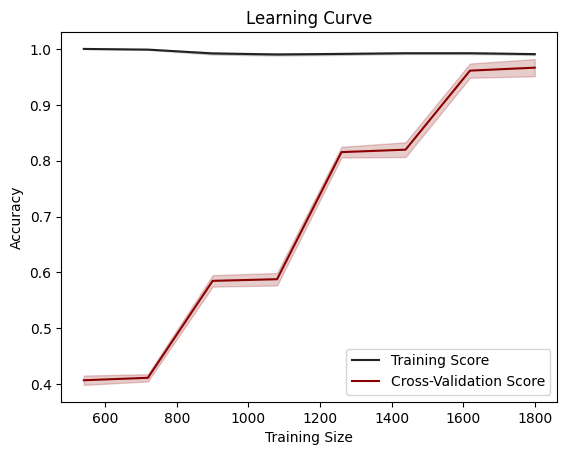

In [32]:
train_sizes, train_scores, test_scores = learning_curve(
    svm_parameter_tune, pca_full, y, cv = 8, scoring = 'accuracy', n_jobs=-1, train_sizes = np.linspace(0.3, 1.0, 8)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Score", color="#222222")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="#8B0000")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#222222", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#8B0000", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Plotting the model accuracy

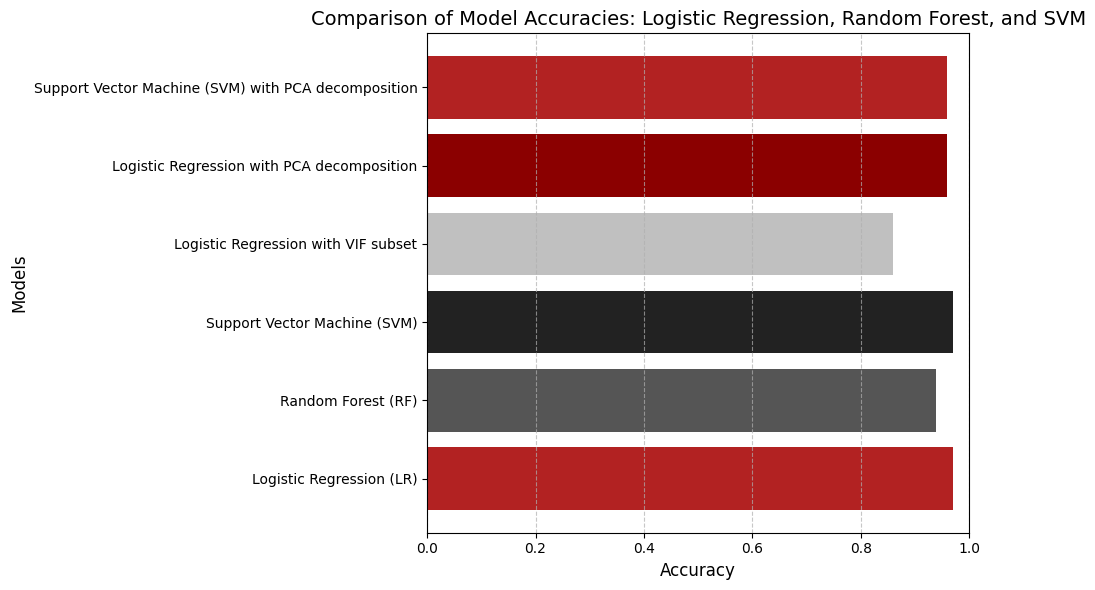

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model accuracies for LR, RF, and SVM from the analysis in the uploaded notebook
model_accuracies = {
    'Logistic Regression (LR)': 0.97,  
    'Random Forest (RF)': 0.94,       
    'Support Vector Machine (SVM)': 0.97,  
    'Logistic Regression with VIF subset': 0.86,
    'Logistic Regression with PCA decomposition': 0.96,
    'Support Vector Machine (SVM) with PCA decomposition': 0.96
}

# Extract model names and accuracies
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Define custom color palette
custom_palette = ['#B22222', '#555555', '#222222', '#C0C0C0', '#8B0000']

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color=custom_palette[:len(models)])
plt.title('Comparison of Model Accuracies: Logistic Regression, Random Forest, and SVM', fontsize=14)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


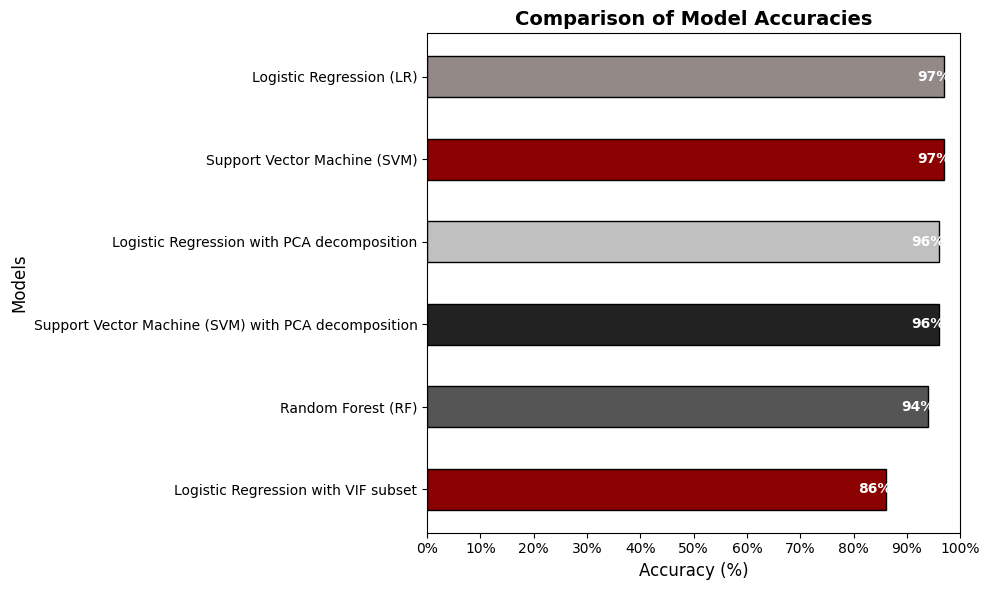

In [21]:
import matplotlib.pyplot as plt

# Updated color palette to reuse one red color from the palette
custom_palette = ['#8B0000', '#555555', '#222222', '#C0C0C0', '#8B0000', '#938A88']

# Define model accuracies for LR, RF, and SVM from the analysis
model_accuracies = {
    'Logistic Regression (LR)': 0.97,  
    'Random Forest (RF)': 0.94,       
    'Support Vector Machine (SVM)': 0.97,  
    'Logistic Regression with VIF subset': 0.86,
    'Logistic Regression with PCA decomposition': 0.96,
    'Support Vector Machine (SVM) with PCA decomposition': 0.96
}

# Sort models by accuracy in descending order
sorted_model_accuracies = dict(sorted(model_accuracies.items(), key=lambda item: item[1], reverse=True))

# Extract sorted model names and accuracies
models = list(sorted_model_accuracies.keys())
accuracies = [accuracy * 100 for accuracy in sorted_model_accuracies.values()]  # Convert to percentages

# Ensure the color palette is reused in the sorted order
custom_palette_sorted = custom_palette[:len(models)]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(models[::-1], accuracies[::-1], color=custom_palette_sorted, edgecolor="black", height=0.5)  # Reverse order for descending display
plt.title('Comparison of Model Accuracies', fontsize=14, weight="bold")
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.xlim(0, 100)  # X-axis from 0 to 100
plt.xticks(ticks=range(0, 101, 10), labels=[f"{x}%" for x in range(0, 101, 10)], fontsize=10)  # Percentage ticks every 10%
plt.yticks(fontsize=10)

# Add value labels inside the bars
for bar in bars:
    plt.text(
        bar.get_width() - 2,  # Slightly inside the bar
        bar.get_y() + bar.get_height() / 2, 
        f"{int(bar.get_width())}%",  # Show percentage without .0
        color="white" if bar.get_width() > 50 else "black",  # Contrast text for readability
        fontsize=10, 
        fontweight="bold", 
        ha="center", 
        va="center"
    )

# Show the plot
plt.tight_layout()
plt.show()
